In [1]:
import numpy as np
import pandas as pd
from river import optim
from river import metrics
from river.drift.binary import EDDM
from sail.telemetry import TracingClient
from sail.models.auto_ml.tune import SAILTuneGridSearchCV
from sail.models.river.forest import AdaptiveRandomForestClassifier
from sail.models.river.linear_model import LogisticRegression
from sail.models.auto_ml.auto_pipeline import SAILAutoPipeline
from sail.pipeline import SAILPipeline
from sklearn.impute import SimpleImputer
from sail.drift_detection.drift_detector import SAILDriftDetector
from sail.transformers.river.preprocessing import StandardScaler

#### Load Data


In [2]:
X = pd.read_csv("../../datasets/agrawal.csv").head(50000)

y = X["class"]
X.drop("class", axis=1, inplace=True)

#### Model Definition


In [3]:
logistic_reg = LogisticRegression(optimizer=optim.SGD(0.1))
random_forest = AdaptiveRandomForestClassifier(n_models=10)

#### Create SAIL Pipeline


In [4]:
steps = [
    ("Imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
    ("standard_scalar", StandardScaler()),
    ("classifier", "passthrough"),
]
sail_pipeline = SAILPipeline(steps=steps, scoring=metrics.Accuracy, verbosity_level=1, verbosity_interval=1)

#### HPO Params


In [5]:
params_grid = [
    {
        "classifier": [logistic_reg],
        "classifier__l2": [0.1, 0.9],
        "classifier__intercept_init": [0.2, 0.5],
    },
    {
        "classifier": [random_forest],
        "classifier__n_models": [5, 10],
        "Imputer": ["passthrough"],
    },
]

# params_grid = {
#     "classifier__l2": [0.1, 0.9],
#     "classifier__intercept_init": [0.2, 0.5],
# }


#### Create Model Instance


In [6]:
tracer = TracingClient(service_name="SAIL_Testing", oltp_endpoint="http://master.more2020.eu:31318")
auto_pipeline = SAILAutoPipeline(
    pipeline=sail_pipeline,
    pipeline_params_grid=params_grid,
    search_method=SAILTuneGridSearchCV,
    search_method_params={
        "num_cpus_per_trial": 1,
        "max_iters": 1,
        "early_stopping": False,
        "mode": "max",
        "scoring": "accuracy",
        "pipeline_auto_early_stop": False,
        "keep_best_configurations": 2
    },
    search_data_size=1000,
    incremental_training=True,
    drift_detector=SAILDriftDetector(model=EDDM(), drift_param="difference"),
    pipeline_strategy="DetectAndIncrement",
    verbosity_level=1, 
    verbosity_interval=1,
    tensorboard_log_dir=None,
    tracer=tracer
)

[2023-09-20 03:15:34:857] - INFO - SAIL (PipelineStrategy) - Pipeline Strategy [DetectAndIncrement] created with actions: ['DATA_COLLECTION', 'FIND_BEST_PIPELINE', 'SCORE_AND_DETECT_DRIFT', 'PARTIAL_FIT_MODEL']


#### Start Training


In [7]:
y_preds = []
y_true = []
batch_size = 50

with tracer.trace_as_current(span_name="Pipeline-Train"):
    for start in range(0, 2000, batch_size):

        end = start + batch_size

        X_train = X.iloc[start:end]
        y_train = y.iloc[start:end]

        if end > 1000: # search_data_size is 1000
            preds = auto_pipeline.predict(X_train)
            if preds is not None:
                y_preds.extend(list(preds))
                y_true.extend(list(y_train))

        auto_pipeline.train(X_train, y_train, classifier__classes=[1, 0])


2023-09-20 03:15:45,434	INFO tune.py:1148 -- Total run time: 7.43 seconds (7.41 seconds for the tuning loop).



>>> Epoch: 1 | Samples Seen: 0 -------------------------------------------------------------------------------------


SAIL Pipeline fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.800s, Batch Size=1000, Score=0.944]             
[2023-09-20 03:15:47:714] - INFO - SAIL (PipelineStrategy) - Pipeline tuning completed. Disconnecting Ray cluster...
[2023-09-20 03:15:47:715] - INFO - SAIL (PipelineStrategy) - Found best params: {'Imputer': 'passthrough', 'classifier': AdaptiveRandomForestClassifier(drift_detector=ADWIN (
      delta=0.001
      clock=32
      max_buckets=5
      min_window_length=5
      grace_period=10
    ),
                                   metric=Accuracy: 0.00%,
                                   warning_detector=ADWIN (
      delta=0.01
      clock=32
      max_buckets=5
      min_window_length=5
      grace_period=10
    )), 'classifier__n_models': 10}



>>> Epoch: 21 | Samples Seen: 1000 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0016s, Metric=Accuracy, Batch Size=50, P_Score=0.96]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0009s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.048s, Batch Size=50, P_Score=0.96]             



>>> Epoch: 22 | Samples Seen: 1050 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0013s, Metric=Accuracy, Batch Size=50, P_Score=0.95]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0009s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.067s, Batch Size=50, P_Score=0.95]             



>>> Epoch: 23 | Samples Seen: 1100 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0014s, Metric=Accuracy, Batch Size=50, P_Score=0.92]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0010s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.063s, Batch Size=50, P_Score=0.92]             



>>> Epoch: 24 | Samples Seen: 1150 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0021s, Metric=Accuracy, Batch Size=50, P_Score=0.93]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0009s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.050s, Batch Size=50, P_Score=0.93]             



>>> Epoch: 25 | Samples Seen: 1200 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0017s, Metric=Accuracy, Batch Size=50, P_Score=0.912]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0011s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.056s, Batch Size=50, P_Score=0.912]             



>>> Epoch: 26 | Samples Seen: 1250 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0013s, Metric=Accuracy, Batch Size=50, P_Score=0.907]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0009s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.050s, Batch Size=50, P_Score=0.907]             



>>> Epoch: 27 | Samples Seen: 1300 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0014s, Metric=Accuracy, Batch Size=50, P_Score=0.917]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0009s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.058s, Batch Size=50, P_Score=0.917]             



>>> Epoch: 28 | Samples Seen: 1350 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0015s, Metric=Accuracy, Batch Size=50, P_Score=0.917]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0010s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.046s, Batch Size=50, P_Score=0.917]             



>>> Epoch: 29 | Samples Seen: 1400 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0014s, Metric=Accuracy, Batch Size=50, P_Score=0.918]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0008s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.049s, Batch Size=50, P_Score=0.918]             



>>> Epoch: 30 | Samples Seen: 1450 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0017s, Metric=Accuracy, Batch Size=50, P_Score=0.916]
SAIL Drift detection:  14%=          [Points: 7/50, Elapsed:0.0011s, Detector=EDDM, Batch Size=50, Param=differene, Drift=Yes]
[2023-09-20 03:15:48:584] - INFO - SAIL (PipelineStrategy) - Drift Detected in the data. Final Estimator will be incrementally trained on the next train()
[2023-09-20 03:15:48:584] - WARNING - SAIL (SAILAutoPipeline) - The current best pipeline is STALE. Pipeline becomes stale when data drift occurs. You can call 'train' with fresh data to get the best pipeline.



>>> Epoch: 31 | Samples Seen: 1500 -------------------------------------------------------------------------------------


SAIL Model Partial fit: 100%========== [ETA: 00:00<00:00, Elapsed:0.069s, Model=AdaptiveRandomForestClassifier, Batch Size=50, P_Score=0.918]



>>> Epoch: 32 | Samples Seen: 1550 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0016s, Metric=Accuracy, Batch Size=50, P_Score=0.922]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0011s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.063s, Batch Size=50, P_Score=0.922]             



>>> Epoch: 33 | Samples Seen: 1600 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0014s, Metric=Accuracy, Batch Size=50, P_Score=0.916]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0008s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.054s, Batch Size=50, P_Score=0.916]             



>>> Epoch: 34 | Samples Seen: 1650 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0020s, Metric=Accuracy, Batch Size=50, P_Score=0.915]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0010s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.055s, Batch Size=50, P_Score=0.915]             



>>> Epoch: 35 | Samples Seen: 1700 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0016s, Metric=Accuracy, Batch Size=50, P_Score=0.917]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0009s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.052s, Batch Size=50, P_Score=0.917]             



>>> Epoch: 36 | Samples Seen: 1750 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0025s, Metric=Accuracy, Batch Size=50, P_Score=0.916]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0017s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.060s, Batch Size=50, P_Score=0.916]             



>>> Epoch: 37 | Samples Seen: 1800 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0014s, Metric=Accuracy, Batch Size=50, P_Score=0.917]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0010s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.065s, Batch Size=50, P_Score=0.917]             


>>> Epoch: 38 | Samples Seen: 1850 -------------------------------------------------------------------------------------

SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0018s, Metric=Accuracy, Batch Size=50, P_Score=0.917]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0009s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.056s, Batch Size=50, P_Score=0.917]             



>>> Epoch: 39 | Samples Seen: 1900 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0020s, Metric=Accuracy, Batch Size=50, P_Score=0.919]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0012s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.049s, Batch Size=50, P_Score=0.919]             



>>> Epoch: 40 | Samples Seen: 1950 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0017s, Metric=Accuracy, Batch Size=50, P_Score=0.92]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0011s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.053s, Batch Size=50, P_Score=0.92]             


#### Save model


In [8]:
auto_pipeline.save_model(".")

'./sail_auto_pipeline'

#### Load model


In [9]:
new_auto_pipeline = SAILAutoPipeline.load_model(".")

[2023-09-11 00:12:45:233] - INFO - SAIL (PipelineStrategy) - Pipeline Strategy [DetectAndIncrement] created with actions: ['DATA_COLLECTION', 'FIND_BEST_PIPELINE', 'SCORE_AND_DETECT_DRIFT', 'PARTIAL_FIT_MODEL']
SAIL Pipeline Progressive Score: 100%========== [Points: 850/850, Elapsed:0.0021s, Metric=Accuracy, Batch Size=850, P_Score=0.92]


#### Continue training using the load model


In [10]:
for start in range(1501, 3001, batch_size):

    end = start + batch_size

    X_train = X.iloc[start:end]
    y_train = y.iloc[start:end]

    if end > 1000: # search_data_size is 1000
        preds = new_auto_pipeline.predict(X_train)
        if preds is not None:
            y_preds.extend(list(preds))
            y_true.extend(list(y_train))

    new_auto_pipeline.train(X_train, y_train, classifier__classes=[1, 0])



>>> Epoch: 31 | Samples Seen: 1500 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0019s, Metric=Accuracy, Batch Size=50, P_Score=0.92]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0101s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.057s, Batch Size=50, P_Score=0.92]             



>>> Epoch: 32 | Samples Seen: 1550 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0015s, Metric=Accuracy, Batch Size=50, P_Score=0.923]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0013s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.057s, Batch Size=50, P_Score=0.923]             



>>> Epoch: 33 | Samples Seen: 1600 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0013s, Metric=Accuracy, Batch Size=50, P_Score=0.92]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0009s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.055s, Batch Size=50, P_Score=0.92]             



>>> Epoch: 34 | Samples Seen: 1650 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0014s, Metric=Accuracy, Batch Size=50, P_Score=0.92]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0010s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.052s, Batch Size=50, P_Score=0.92]             



>>> Epoch: 35 | Samples Seen: 1700 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0014s, Metric=Accuracy, Batch Size=50, P_Score=0.92]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0009s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.064s, Batch Size=50, P_Score=0.92]             



>>> Epoch: 36 | Samples Seen: 1750 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0015s, Metric=Accuracy, Batch Size=50, P_Score=0.92]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0010s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.053s, Batch Size=50, P_Score=0.92]             



>>> Epoch: 37 | Samples Seen: 1800 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0014s, Metric=Accuracy, Batch Size=50, P_Score=0.922]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0011s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.053s, Batch Size=50, P_Score=0.922]             



>>> Epoch: 38 | Samples Seen: 1850 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0014s, Metric=Accuracy, Batch Size=50, P_Score=0.924]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0010s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.055s, Batch Size=50, P_Score=0.924]             



>>> Epoch: 39 | Samples Seen: 1900 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0015s, Metric=Accuracy, Batch Size=50, P_Score=0.925]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0010s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.064s, Batch Size=50, P_Score=0.925]             



>>> Epoch: 40 | Samples Seen: 1950 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0014s, Metric=Accuracy, Batch Size=50, P_Score=0.927]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0012s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.058s, Batch Size=50, P_Score=0.927]             



>>> Epoch: 41 | Samples Seen: 2000 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0015s, Metric=Accuracy, Batch Size=50, P_Score=0.927]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0012s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.052s, Batch Size=50, P_Score=0.927]             



>>> Epoch: 42 | Samples Seen: 2050 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0013s, Metric=Accuracy, Batch Size=50, P_Score=0.929]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0010s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.048s, Batch Size=50, P_Score=0.929]             



>>> Epoch: 43 | Samples Seen: 2100 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0015s, Metric=Accuracy, Batch Size=50, P_Score=0.929]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0009s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.051s, Batch Size=50, P_Score=0.929]             



>>> Epoch: 44 | Samples Seen: 2150 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0016s, Metric=Accuracy, Batch Size=50, P_Score=0.928]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0009s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.049s, Batch Size=50, P_Score=0.928]             



>>> Epoch: 45 | Samples Seen: 2200 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0014s, Metric=Accuracy, Batch Size=50, P_Score=0.93]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0065s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.057s, Batch Size=50, P_Score=0.93]             



>>> Epoch: 46 | Samples Seen: 2250 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0018s, Metric=Accuracy, Batch Size=50, P_Score=0.93]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0014s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.054s, Batch Size=50, P_Score=0.93]             


>>> Epoch: 47 | Samples Seen: 2300 -------------------------------------------------------------------------------------



SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0024s, Metric=Accuracy, Batch Size=50, P_Score=0.929]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0012s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.058s, Batch Size=50, P_Score=0.929]             



>>> Epoch: 48 | Samples Seen: 2350 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0020s, Metric=Accuracy, Batch Size=50, P_Score=0.929]
SAIL Drift detection:   4%           [Points: 2/50, Elapsed:0.0021s, Detector=EDDM, Batch Size=50, Param=differene, Drift=Yes]
[2023-09-11 00:12:47:69] - INFO - SAIL (PipelineStrategy) - Drift Detected in the data. Final Estimator will be incrementally trained on the next train()
[2023-09-11 00:12:47:70] - WARNING - SAIL (SAILAutoPipeline) - The current best pipeline is STALE. Pipeline becomes stale when data drift occurs. You can call 'train' with fresh data to get the best pipeline.



>>> Epoch: 49 | Samples Seen: 2400 -------------------------------------------------------------------------------------


SAIL Model Partial fit: 100%========== [ETA: 00:00<00:00, Elapsed:0.070s, Model=AdaptiveRandomForestClassifier, Batch Size=50, P_Score=0.929]



>>> Epoch: 50 | Samples Seen: 2450 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0017s, Metric=Accuracy, Batch Size=50, P_Score=0.929]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0011s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.060s, Batch Size=50, P_Score=0.929]             


>>> Epoch: 51 | Samples Seen: 2500 -------------------------------------------------------------------------------------

SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0016s, Metric=Accuracy, Batch Size=50, P_Score=0.931]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0013s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.054s, Batch Size=50, P_Score=0.931]             



>>> Epoch: 52 | Samples Seen: 2550 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0016s, Metric=Accuracy, Batch Size=50, P_Score=0.928]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0014s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.059s, Batch Size=50, P_Score=0.928]             



>>> Epoch: 53 | Samples Seen: 2600 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0018s, Metric=Accuracy, Batch Size=50, P_Score=0.926]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0011s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.057s, Batch Size=50, P_Score=0.926]             



>>> Epoch: 54 | Samples Seen: 2650 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0018s, Metric=Accuracy, Batch Size=50, P_Score=0.926]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0015s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.063s, Batch Size=50, P_Score=0.926]             



>>> Epoch: 55 | Samples Seen: 2700 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0041s, Metric=Accuracy, Batch Size=50, P_Score=0.925]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0014s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.061s, Batch Size=50, P_Score=0.925]             



>>> Epoch: 56 | Samples Seen: 2750 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0017s, Metric=Accuracy, Batch Size=50, P_Score=0.925]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0013s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.058s, Batch Size=50, P_Score=0.925]             



>>> Epoch: 57 | Samples Seen: 2800 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0019s, Metric=Accuracy, Batch Size=50, P_Score=0.926]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0011s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.061s, Batch Size=50, P_Score=0.926]             



>>> Epoch: 58 | Samples Seen: 2850 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0018s, Metric=Accuracy, Batch Size=50, P_Score=0.926]
SAIL Drift detection:   6%           [Points: 3/50, Elapsed:0.0018s, Detector=EDDM, Batch Size=50, Param=differene, Drift=Yes]
[2023-09-11 00:12:48:31] - INFO - SAIL (PipelineStrategy) - Drift Detected in the data. Final Estimator will be incrementally trained on the next train()
[2023-09-11 00:12:48:31] - WARNING - SAIL (SAILAutoPipeline) - The current best pipeline is STALE. Pipeline becomes stale when data drift occurs. You can call 'train' with fresh data to get the best pipeline.



>>> Epoch: 59 | Samples Seen: 2900 -------------------------------------------------------------------------------------


SAIL Model Partial fit: 100%========== [ETA: 00:00<00:00, Elapsed:0.066s, Model=AdaptiveRandomForestClassifier, Batch Size=50, P_Score=0.926]



>>> Epoch: 60 | Samples Seen: 2950 -------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0035s, Metric=Accuracy, Batch Size=50, P_Score=0.926]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0013s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.052s, Batch Size=50, P_Score=0.926]             


#### Classification Report


In [11]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1324
           1       0.95      0.81      0.88       676

    accuracy                           0.92      2000
   macro avg       0.93      0.90      0.91      2000
weighted avg       0.92      0.92      0.92      2000



#### Plot confusion matrix


<Axes: >

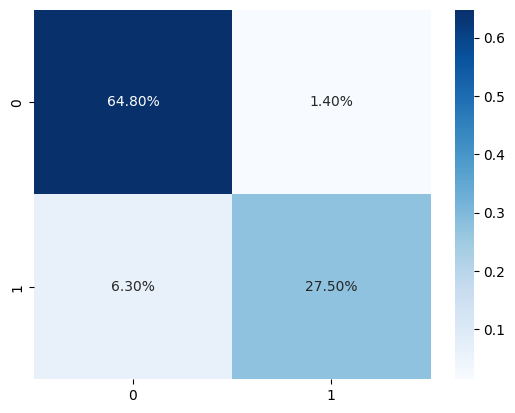

In [12]:
import seaborn as sns

cf_matrix = confusion_matrix(y_true, y_preds)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')